In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain_openai import OpenAIEmbeddings, ChatOpenAI

embeddings = OpenAIEmbeddings()
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

In [2]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import Graph

In [3]:
loader = DirectoryLoader("./data" ,glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap = 50
)

new_docs = text_splitter.split_documents(documents = docs)
doc_strings = [doc.page_content for doc in new_docs]

db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs = {"k":3})

query = "what is meta llama3"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

C:\Users\Asad\AppData\Local\Temp\ipykernel_23156\43134128.py:16: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


{'source': 'data\\llama 3.txt'}
Today, we’re excited to share the first two models of the next generation of Llama, Meta Llama 3, available for broad use. This release features pretrained and instruction-fine-tuned language models with 8B and 70B parameters that can support a broad range of use cases. This next generation of Llama demonstrates state-of-the-art performance on a wide range of industry benchmarks and offers new capabilities, including improved reasoning. We believe these are the best open source models of their class, period. In support of our longstanding open approach, we’re putting Llama 3 in the hands of


In [5]:
query = "what is meta llama3"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': 'data\\llama 3.txt'}
Today, we’re excited to share the first two models of the next generation of Llama, Meta Llama 3, available for broad use. This release features pretrained and instruction-fine-tuned language models with 8B and 70B parameters that can support a broad range of use cases. This next generation of Llama demonstrates state-of-the-art performance on a wide range of industry benchmarks and offers new capabilities, including improved reasoning. We believe these are the best open source models of their class, period. In support of our longstanding open approach, we’re putting Llama 3 in the hands of
page_content='Today, we’re excited to share the first two models of the next generation of Llama, Meta Llama 3, available for broad use. This release features pretrained and instruction-fine-tuned language models with 8B and 70B parameters that can support a broad range of use cases. This next generation of Llama demonstrates state-of-the-art performance on a wide ran

In [6]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


In [7]:
from pydantic import BaseModel, Field
class TopicSelectorParser(BaseModel):
    Topic: str = Field(description="Selected Topic")
    Reasoning: str = Field(description="Reasoning behind topic selection")

In [18]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectorParser)

In [19]:
def function1(state):
    message = state["messages"]
    question = message[-1]
    print(question)

    template = """
    Your task is to classify the given user query into one of the following categories: [llama, Not Related]
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instruction}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=[question],
        partial_variables={
            "format_instructions": parser.get_format_instructions()
        }

        
    )

    chain = prompt | llm | parser

    response = chain.invoke({"question":question, "format_instruction":parser.get_format_instructions()})

    print(response)

    return {"messages": [response.Topic]}

In [20]:
def route(state):
    print("-> Router ->")

    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)

    if "llama" in last_message:
        return "RAG Call"
    else:
        return "LLM Call"

In [21]:
def function2(AgentState):
    messages = AgentState["messages"]
    question = messages[0]

    template = """Answer the question based on the following context:
    {context}
    
    question: {question}"""

    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context":retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    result = retrieval_chain.invoke(question)

    return {"messages":[result]}


In [22]:
def function3(state):
    print("-> Calling LLM")

    messages = state["messages"]
    question = messages[0]

    complete_query = "Answer the following with your knowledge of real world. Here is the question:" + question

    response = llm.invoke(complete_query)

    return {"messages": [response.content]}



In [23]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)
workflow.add_node("agent", function1)
workflow.add_node("RAG", function2)
workflow.add_node("LLM", function3)
workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    route,
    {
        "RAG Call":"RAG",
        "LLM Call": "LLM"
    }
)
workflow.add_edge("RAG", END)
workflow.add_edge("LLM", END)
app = workflow.compile()

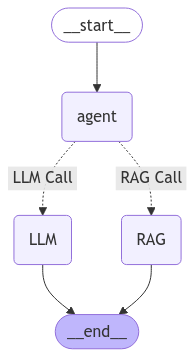

In [24]:
app

In [27]:
inputs = {"messages":["Tell me about World War 2"]}

In [28]:
app.invoke(inputs)

Tell me about World War 2
Topic='Not Related' Reasoning='The query is about World War 2, which is unrelated to llamas.'
-> Router ->
Not Related
-> Calling LLM


{'messages': ['Tell me about World War 2',
  'Not Related',
  "World War II was a global conflict that lasted from 1939 to 1945, involving most of the world's nations and resulting in significant political, social, and economic changes. It was the deadliest conflict in human history, leading to an estimated 70 to 85 million fatalities.\n\n### Major Causes:\n1. **Treaty of Versailles**: The harsh penalties imposed on Germany after World War I created resentment and economic hardship, contributing to the rise of Adolf Hitler and the Nazi Party.\n2. **Expansionist Policies**: Aggressive territorial expansion by Germany, Italy, and Japan violated international agreements and heightened tensions in Europe and Asia.\n3. **Failure of Diplomacy**: The League of Nations failed to effectively address aggression by Axis powers, leading to a breakdown in international order.\n\n### Key Events:\n1. **Invasion of Poland**: The war began on September 1, 1939, when Germany invaded Poland. Britain and 